# Enhanced Maveric Cell Tower Analytics

This notebook provides comprehensive analysis and visualization of cell tower logs with improved insights and actionable metrics.

In [ ]:
# Setup and imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, timezone
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Setup path for imports
ROOT = Path.cwd()
if (ROOT / "notebooks").exists() and not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

from dotenv import load_dotenv
load_dotenv()

from src.common.db import get_logs_collection

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Setup complete")

✅ Setup complete


In [10]:
# Data loading and preprocessing
ANALYSIS_WINDOW_HOURS = 2  # Analyze last N hours

def load_data(hours=ANALYSIS_WINDOW_HOURS):
    """Load and preprocess cell tower data"""
    coll = get_logs_collection()
    since = datetime.now(timezone.utc) - timedelta(hours=hours)
    
    cursor = coll.find({"ts": {"$gte": since}}).sort("ts", 1)
    docs = list(cursor)
    
    if not docs:
        print(f"⚠️ No data found in last {hours} hours")
        return pd.DataFrame()
    
    # Convert to DataFrame
    df = pd.DataFrame(docs)
    df['ts'] = pd.to_datetime(df['ts'])
    df['status_numeric'] = df['status'].map({'ON': 1, 'OFF': 0})
    
    print(f"📊 Loaded {len(df)} records from {len(df['cell_id'].unique())} cells")
    print(f"📅 Time range: {df['ts'].min()} to {df['ts'].max()}")
    
    return df

df = load_data()
if df.empty:
    print("❌ No data available for analysis")
else:
    print(f"✅ Data loaded successfully")
    display(df.head())

📊 Loaded 336 records from 12 cells
📅 Time range: 2025-08-20 20:44:27.866000 to 2025-08-20 20:44:55.268000
✅ Data loaded successfully


,_id,cell_id,status,ts,run_id,cluster,status_numeric
0,68a633abb4a9a06520e7e0ef,1,OFF,2025-08-20 20:44:27.866,1,None,0
1,68a633abb4a9a06520e7e0f0,2,OFF,2025-08-20 20:44:27.866,1,None,0
2,68a633abb4a9a06520e7e0f1,3,ON,2025-08-20 20:44:27.866,1,None,1
3,68a633abb4a9a06520e7e0f2,4,ON,2025-08-20 20:44:27.866,1,None,1
4,68a633abb4a9a06520e7e0f3,5,ON,2025-08-20 20:44:27.866,1,None,1


## 📈 System Overview Dashboard

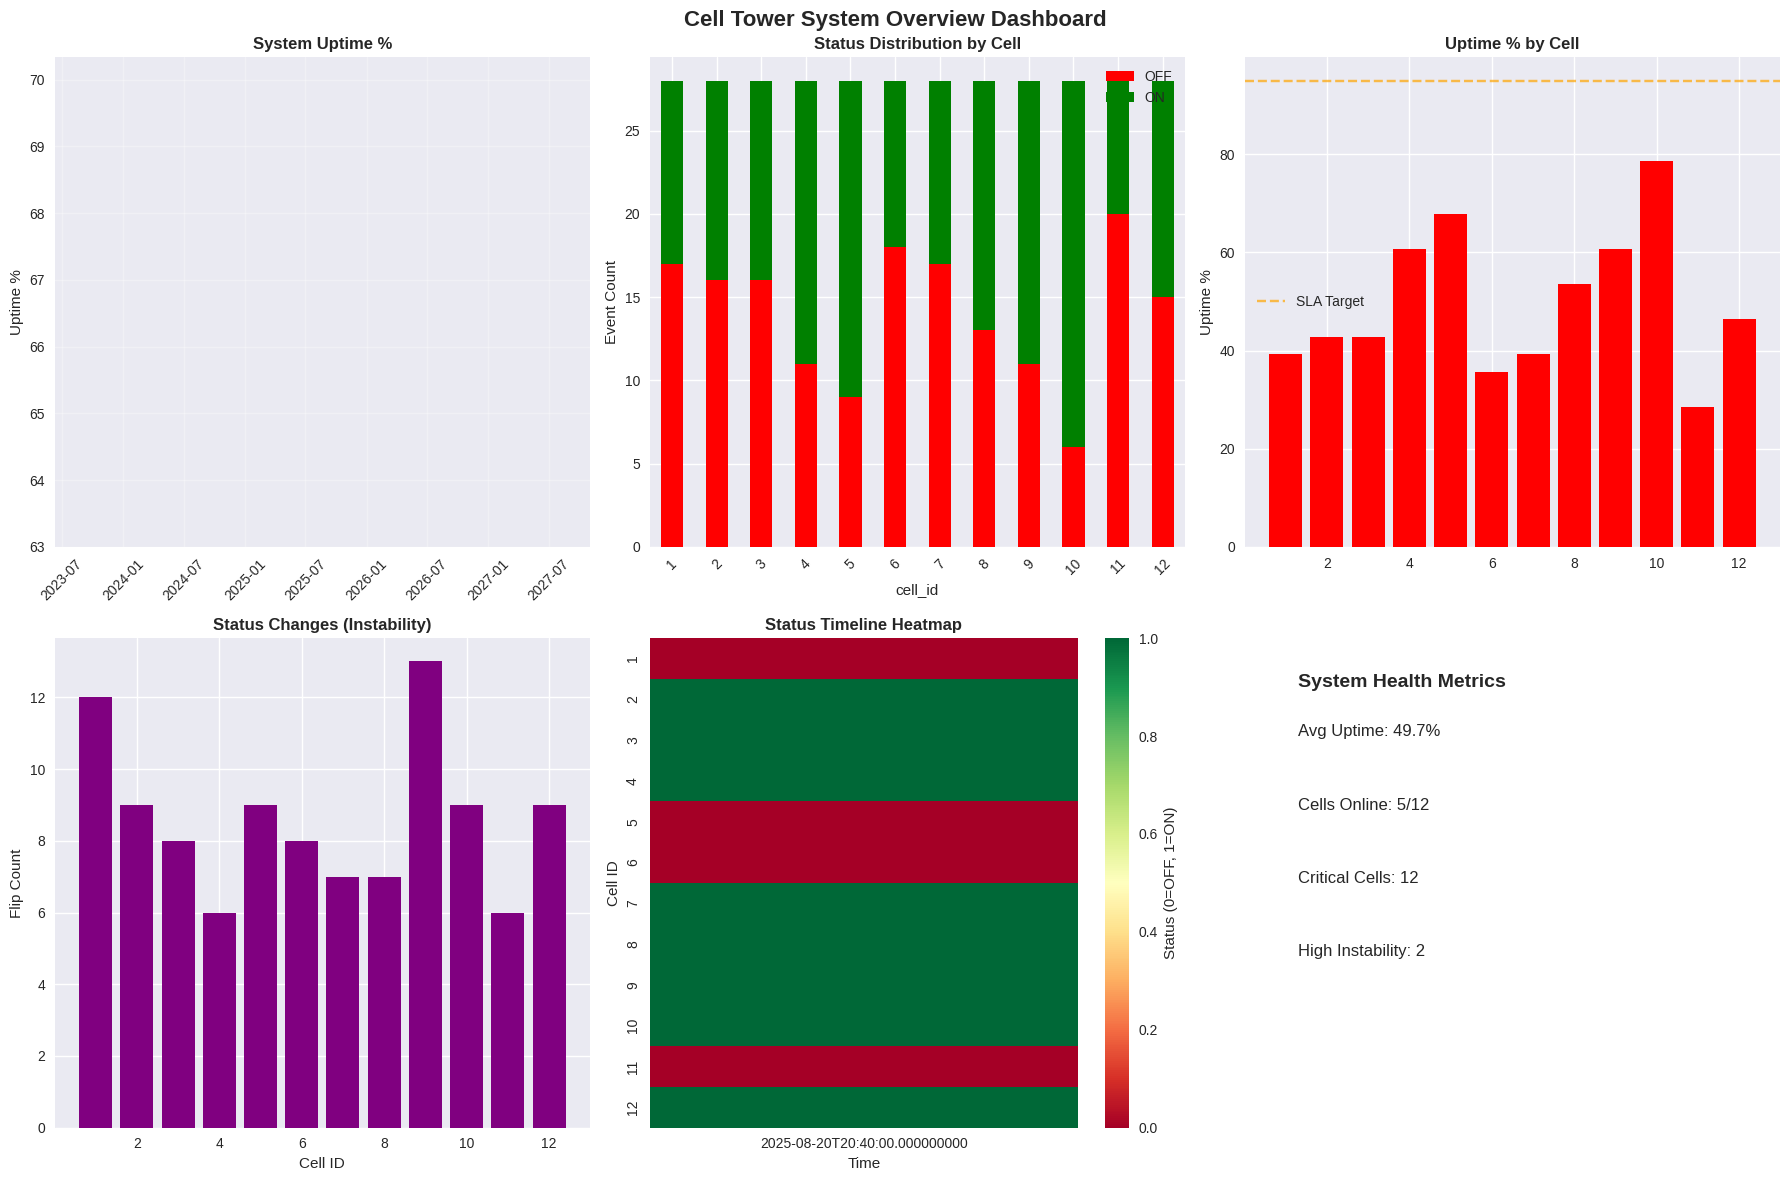


🔍 KEY INSIGHTS:
• Average system uptime: 49.7%
• Cells below 95% SLA: 12/12
• Most unstable cell: 9 (13 flips)
• Best performing cell: 10 (78.6% uptime)


In [11]:
if not df.empty:
    # Create comprehensive dashboard
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Cell Tower System Overview Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Overall system status over time
    df_resampled = df.set_index('ts').groupby('cell_id')['status_numeric'].resample('5T').last().reset_index()
    system_status = df_resampled.groupby('ts')['status_numeric'].agg(['mean', 'count']).reset_index()
    
    axes[0,0].plot(system_status['ts'], system_status['mean'] * 100, linewidth=2, color='green')
    axes[0,0].set_title('System Uptime %', fontweight='bold')
    axes[0,0].set_ylabel('Uptime %')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Cell status distribution
    status_counts = df.groupby(['cell_id', 'status']).size().unstack(fill_value=0)
    status_counts.plot(kind='bar', stacked=True, ax=axes[0,1], color=['red', 'green'])
    axes[0,1].set_title('Status Distribution by Cell', fontweight='bold')
    axes[0,1].set_ylabel('Event Count')
    axes[0,1].legend(['OFF', 'ON'])
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Uptime percentage by cell
    uptime_pct = df.groupby('cell_id')['status_numeric'].mean() * 100
    colors = ['red' if x < 80 else 'orange' if x < 95 else 'green' for x in uptime_pct]
    axes[0,2].bar(uptime_pct.index, uptime_pct.values, color=colors)
    axes[0,2].set_title('Uptime % by Cell', fontweight='bold')
    axes[0,2].set_ylabel('Uptime %')
    axes[0,2].axhline(y=95, color='orange', linestyle='--', alpha=0.7, label='SLA Target')
    axes[0,2].legend()
    
    # 4. Status change frequency (instability indicator)
    def count_flips(group):
        return (group['status'] != group['status'].shift()).sum() - 1
    
    flip_counts = df.groupby('cell_id').apply(count_flips)
    axes[1,0].bar(flip_counts.index, flip_counts.values, color='purple')
    axes[1,0].set_title('Status Changes (Instability)', fontweight='bold')
    axes[1,0].set_ylabel('Flip Count')
    axes[1,0].set_xlabel('Cell ID')
    
    # 5. Event timeline heatmap
    pivot_data = df.set_index('ts').groupby('cell_id')['status_numeric'].resample('10T').last().unstack(level=0)
    if not pivot_data.empty:
        sns.heatmap(pivot_data.T, cmap='RdYlGn', cbar_kws={'label': 'Status (0=OFF, 1=ON)'}, 
                   ax=axes[1,1], xticklabels=10)
        axes[1,1].set_title('Status Timeline Heatmap', fontweight='bold')
        axes[1,1].set_ylabel('Cell ID')
        axes[1,1].set_xlabel('Time')
    
    # 6. System health score
    health_metrics = {
        'Avg Uptime': f"{uptime_pct.mean():.1f}%",
        'Cells Online': f"{(uptime_pct > 50).sum()}/{len(uptime_pct)}",
        'Critical Cells': f"{(uptime_pct < 80).sum()}",
        'High Instability': f"{(flip_counts > flip_counts.quantile(0.8)).sum()}"
    }
    
    axes[1,2].axis('off')
    y_pos = 0.8
    axes[1,2].text(0.1, 0.9, 'System Health Metrics', fontsize=14, fontweight='bold')
    for metric, value in health_metrics.items():
        axes[1,2].text(0.1, y_pos, f'{metric}: {value}', fontsize=12)
        y_pos -= 0.15
    
    plt.tight_layout()
    plt.show()
    
    # Print key insights
    print("\n🔍 KEY INSIGHTS:")
    print(f"• Average system uptime: {uptime_pct.mean():.1f}%")
    print(f"• Cells below 95% SLA: {(uptime_pct < 95).sum()}/{len(uptime_pct)}")
    print(f"• Most unstable cell: {flip_counts.idxmax()} ({flip_counts.max()} flips)")
    print(f"• Best performing cell: {uptime_pct.idxmax()} ({uptime_pct.max():.1f}% uptime)")

## 🚨 Anomaly Detection & Alerting

🚨 ANOMALIES DETECTED:

🔴 HIGH SEVERITY:
  • Cell 1 uptime is only 39.3% (below SLA)
  • Cell 2 uptime is only 42.9% (below SLA)
  • Cell 3 uptime is only 42.9% (below SLA)
  • Cell 6 uptime is only 35.7% (below SLA)
  • Cell 7 uptime is only 39.3% (below SLA)
  • Cell 11 uptime is only 28.6% (below SLA)
  • Cell 12 uptime is only 46.4% (below SLA)

🟡 MEDIUM SEVERITY:
  • Cell 1 changed status 12 times (potential instability)
  • Cell 4 uptime is only 60.7% (below SLA)
  • Cell 5 uptime is only 67.9% (below SLA)
  • Cell 8 uptime is only 53.6% (below SLA)
  • Cell 9 changed status 13 times (potential instability)
  • Cell 9 uptime is only 60.7% (below SLA)
  • Cell 10 uptime is only 78.6% (below SLA)


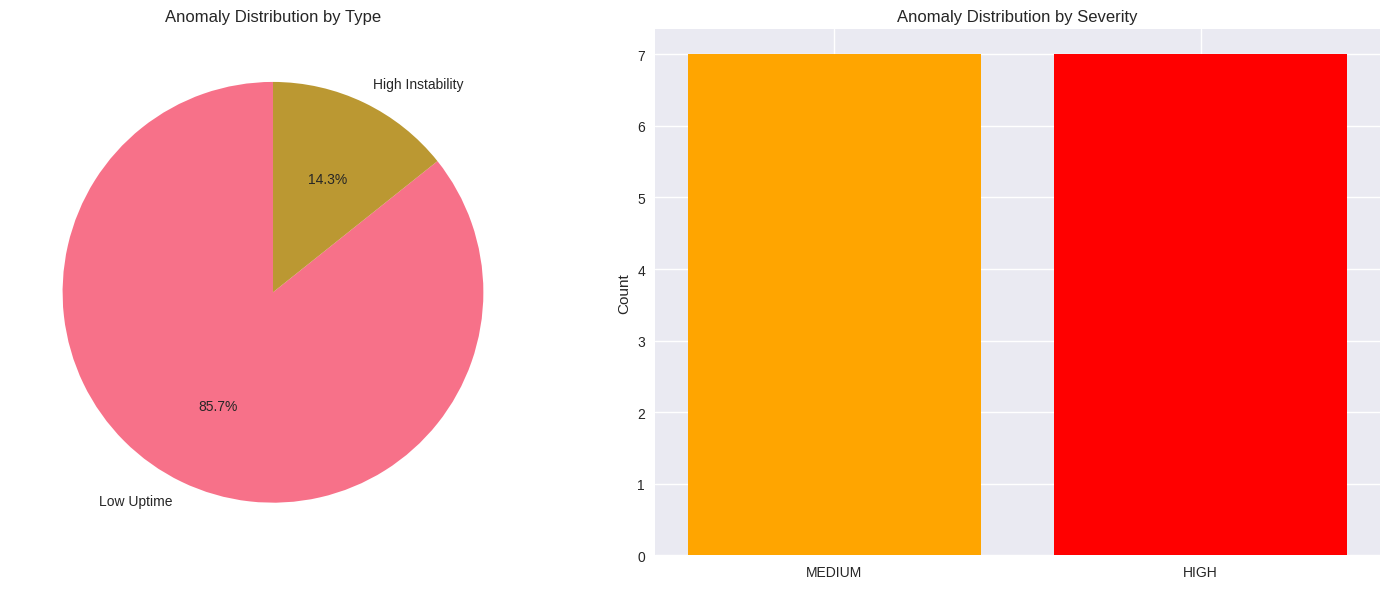

In [12]:
if not df.empty:
    # Advanced anomaly detection
    def detect_anomalies(df):
        anomalies = []
        
        for cell_id in df['cell_id'].unique():
            cell_data = df[df['cell_id'] == cell_id].sort_values('ts')
            
            # 1. Extended downtime detection
            off_periods = []
            current_off_start = None
            
            for _, row in cell_data.iterrows():
                if row['status'] == 'OFF' and current_off_start is None:
                    current_off_start = row['ts']
                elif row['status'] == 'ON' and current_off_start is not None:
                    duration = (row['ts'] - current_off_start).total_seconds() / 60  # minutes
                    off_periods.append(duration)
                    current_off_start = None
            
            if off_periods:
                max_downtime = max(off_periods)
                if max_downtime > 30:  # More than 30 minutes
                    anomalies.append({
                        'cell_id': cell_id,
                        'type': 'Extended Downtime',
                        'severity': 'HIGH' if max_downtime > 60 else 'MEDIUM',
                        'value': f'{max_downtime:.1f} minutes',
                        'description': f'Cell {cell_id} was offline for {max_downtime:.1f} minutes'
                    })
            
            # 2. High flip rate detection
            flips = (cell_data['status'] != cell_data['status'].shift()).sum() - 1
            if flips > 10:  # More than 10 status changes
                anomalies.append({
                    'cell_id': cell_id,
                    'type': 'High Instability',
                    'severity': 'MEDIUM',
                    'value': f'{flips} flips',
                    'description': f'Cell {cell_id} changed status {flips} times (potential instability)'
                })
            
            # 3. Low uptime detection
            uptime = cell_data['status_numeric'].mean() * 100
            if uptime < 80:
                anomalies.append({
                    'cell_id': cell_id,
                    'type': 'Low Uptime',
                    'severity': 'HIGH' if uptime < 50 else 'MEDIUM',
                    'value': f'{uptime:.1f}%',
                    'description': f'Cell {cell_id} uptime is only {uptime:.1f}% (below SLA)'
                })
        
        return anomalies
    
    anomalies = detect_anomalies(df)
    
    if anomalies:
        print("🚨 ANOMALIES DETECTED:")
        print("=" * 50)
        
        # Group by severity
        high_severity = [a for a in anomalies if a['severity'] == 'HIGH']
        medium_severity = [a for a in anomalies if a['severity'] == 'MEDIUM']
        
        if high_severity:
            print("\n🔴 HIGH SEVERITY:")
            for anomaly in high_severity:
                print(f"  • {anomaly['description']}")
        
        if medium_severity:
            print("\n🟡 MEDIUM SEVERITY:")
            for anomaly in medium_severity:
                print(f"  • {anomaly['description']}")
        
        # Visualization of anomalies
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Anomaly count by type
        anomaly_types = [a['type'] for a in anomalies]
        type_counts = pd.Series(anomaly_types).value_counts()
        ax1.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
        ax1.set_title('Anomaly Distribution by Type')
        
        # Severity distribution
        severity_counts = pd.Series([a['severity'] for a in anomalies]).value_counts()
        colors = ['red' if x == 'HIGH' else 'orange' for x in severity_counts.index]
        ax2.bar(severity_counts.index, severity_counts.values, color=colors)
        ax2.set_title('Anomaly Distribution by Severity')
        ax2.set_ylabel('Count')
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("✅ No anomalies detected - system operating normally")

## 📊 Performance Trends & Predictions

⚠️ Not enough data points for trend line.


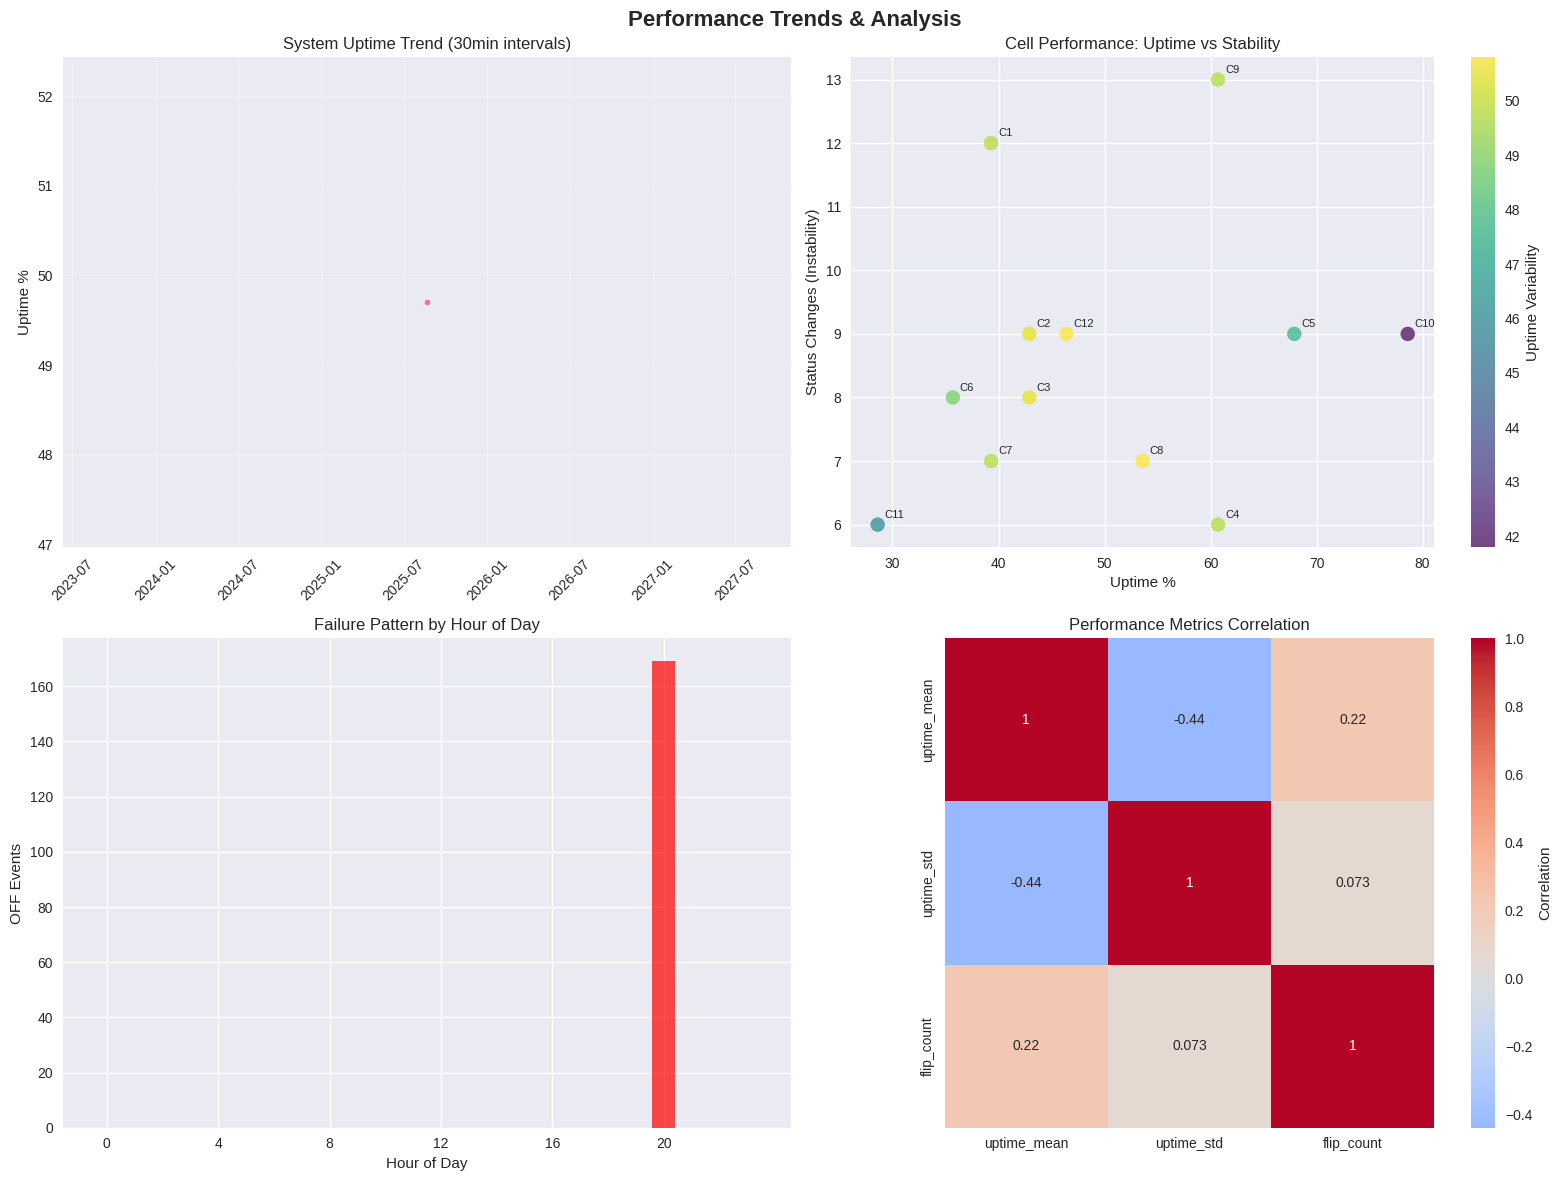


📈 PERFORMANCE INSIGHTS:
• System uptime trend: Declining (0.000%/interval)
• Most reliable cell: 10 (78.6% uptime)
• Most stable cell: 4 (6 flips)
• Peak failure hour: 20:00 (169.0 failures)

💡 RECOMMENDATIONS:
• Priority maintenance needed for Cell 11 (lowest uptime: 28.6%)
• Investigate Cell 9 for instability (13 status changes)
• Consider scheduled maintenance during hour 20:00 (peak failure time)


In [16]:
if not df.empty:
    # Performance trend analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Performance Trends & Analysis', fontsize=16, fontweight='bold')
    
    # 1. Uptime trend over time
    df_hourly = df.set_index('ts').groupby('cell_id')['status_numeric'].resample('30T').mean().reset_index()
    system_hourly = df_hourly.groupby('ts')['status_numeric'].mean() * 100
    
    axes[0,0].plot(system_hourly.index, system_hourly.values, linewidth=2, marker='o', markersize=4)
    axes[0,0].set_title('System Uptime Trend (30min intervals)')
    axes[0,0].set_ylabel('Uptime %')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Add trend line if enough data points
    x_numeric = np.arange(len(system_hourly))
    if len(system_hourly) >= 2 and np.isfinite(system_hourly.values).all():
        z = np.polyfit(x_numeric, system_hourly.values, 1)
        p = np.poly1d(z)
        axes[0,0].plot(system_hourly.index, p(x_numeric), "--", alpha=0.8, color='red')
    else:
        print("⚠️ Not enough data points for trend line.")
        z = [0]  # fallback for insights below
    
    # 2. Cell performance comparison
    cell_metrics = df.groupby('cell_id').agg({
        'status_numeric': ['mean', 'std'],
        'status': lambda x: (x != x.shift()).sum() - 1  # flip count
    }).round(3)
    
    cell_metrics.columns = ['uptime_mean', 'uptime_std', 'flip_count']
    cell_metrics['uptime_mean'] *= 100
    cell_metrics['uptime_std'] *= 100
    
    # Scatter plot: uptime vs stability
    scatter = axes[0,1].scatter(cell_metrics['uptime_mean'], cell_metrics['flip_count'], 
                               c=cell_metrics['uptime_std'], cmap='viridis', s=100, alpha=0.7)
    axes[0,1].set_xlabel('Uptime %')
    axes[0,1].set_ylabel('Status Changes (Instability)')
    axes[0,1].set_title('Cell Performance: Uptime vs Stability')
    plt.colorbar(scatter, ax=axes[0,1], label='Uptime Variability')
    
    # Add cell ID labels
    for idx, row in cell_metrics.iterrows():
        axes[0,1].annotate(f'C{idx}', (row['uptime_mean'], row['flip_count']), 
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 3. Failure pattern analysis
    df['hour'] = df['ts'].dt.hour
    hourly_failures = df[df['status'] == 'OFF'].groupby('hour').size()
    all_hours = pd.Series(0, index=range(24))
    hourly_failures = all_hours.add(hourly_failures, fill_value=0)
    
    axes[1,0].bar(hourly_failures.index, hourly_failures.values, color='red', alpha=0.7)
    axes[1,0].set_title('Failure Pattern by Hour of Day')
    axes[1,0].set_xlabel('Hour of Day')
    axes[1,0].set_ylabel('OFF Events')
    axes[1,0].set_xticks(range(0, 24, 4))
    
    # 4. Correlation matrix
    correlation_data = cell_metrics[['uptime_mean', 'uptime_std', 'flip_count']]
    corr_matrix = correlation_data.corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=axes[1,1], cbar_kws={'label': 'Correlation'})
    axes[1,1].set_title('Performance Metrics Correlation')
    
    plt.tight_layout()
    plt.show()
    
    # Performance insights
    print("\n📈 PERFORMANCE INSIGHTS:")
    print(f"• System uptime trend: {'Improving' if z[0] > 0 else 'Declining'} ({z[0]:.3f}%/interval)")
    print(f"• Most reliable cell: {cell_metrics['uptime_mean'].idxmax()} ({cell_metrics['uptime_mean'].max():.1f}% uptime)")
    print(f"• Most stable cell: {cell_metrics['flip_count'].idxmin()} ({cell_metrics['flip_count'].min()} flips)")
    print(f"• Peak failure hour: {hourly_failures.idxmax()}:00 ({hourly_failures.max()} failures)")
    
    # Recommendations
    print("\n💡 RECOMMENDATIONS:")
    worst_uptime = cell_metrics['uptime_mean'].idxmin()
    most_unstable = cell_metrics['flip_count'].idxmax()
    
    print(f"• Priority maintenance needed for Cell {worst_uptime} (lowest uptime: {cell_metrics.loc[worst_uptime, 'uptime_mean']:.1f}%)")
    print(f"• Investigate Cell {most_unstable} for instability ({cell_metrics.loc[most_unstable, 'flip_count']} status changes)")
    
    if hourly_failures.max() > hourly_failures.mean() * 1.5:
        print(f"• Consider scheduled maintenance during hour {hourly_failures.idxmax()}:00 (peak failure time)")

## 🎯 SLA Compliance & Reporting

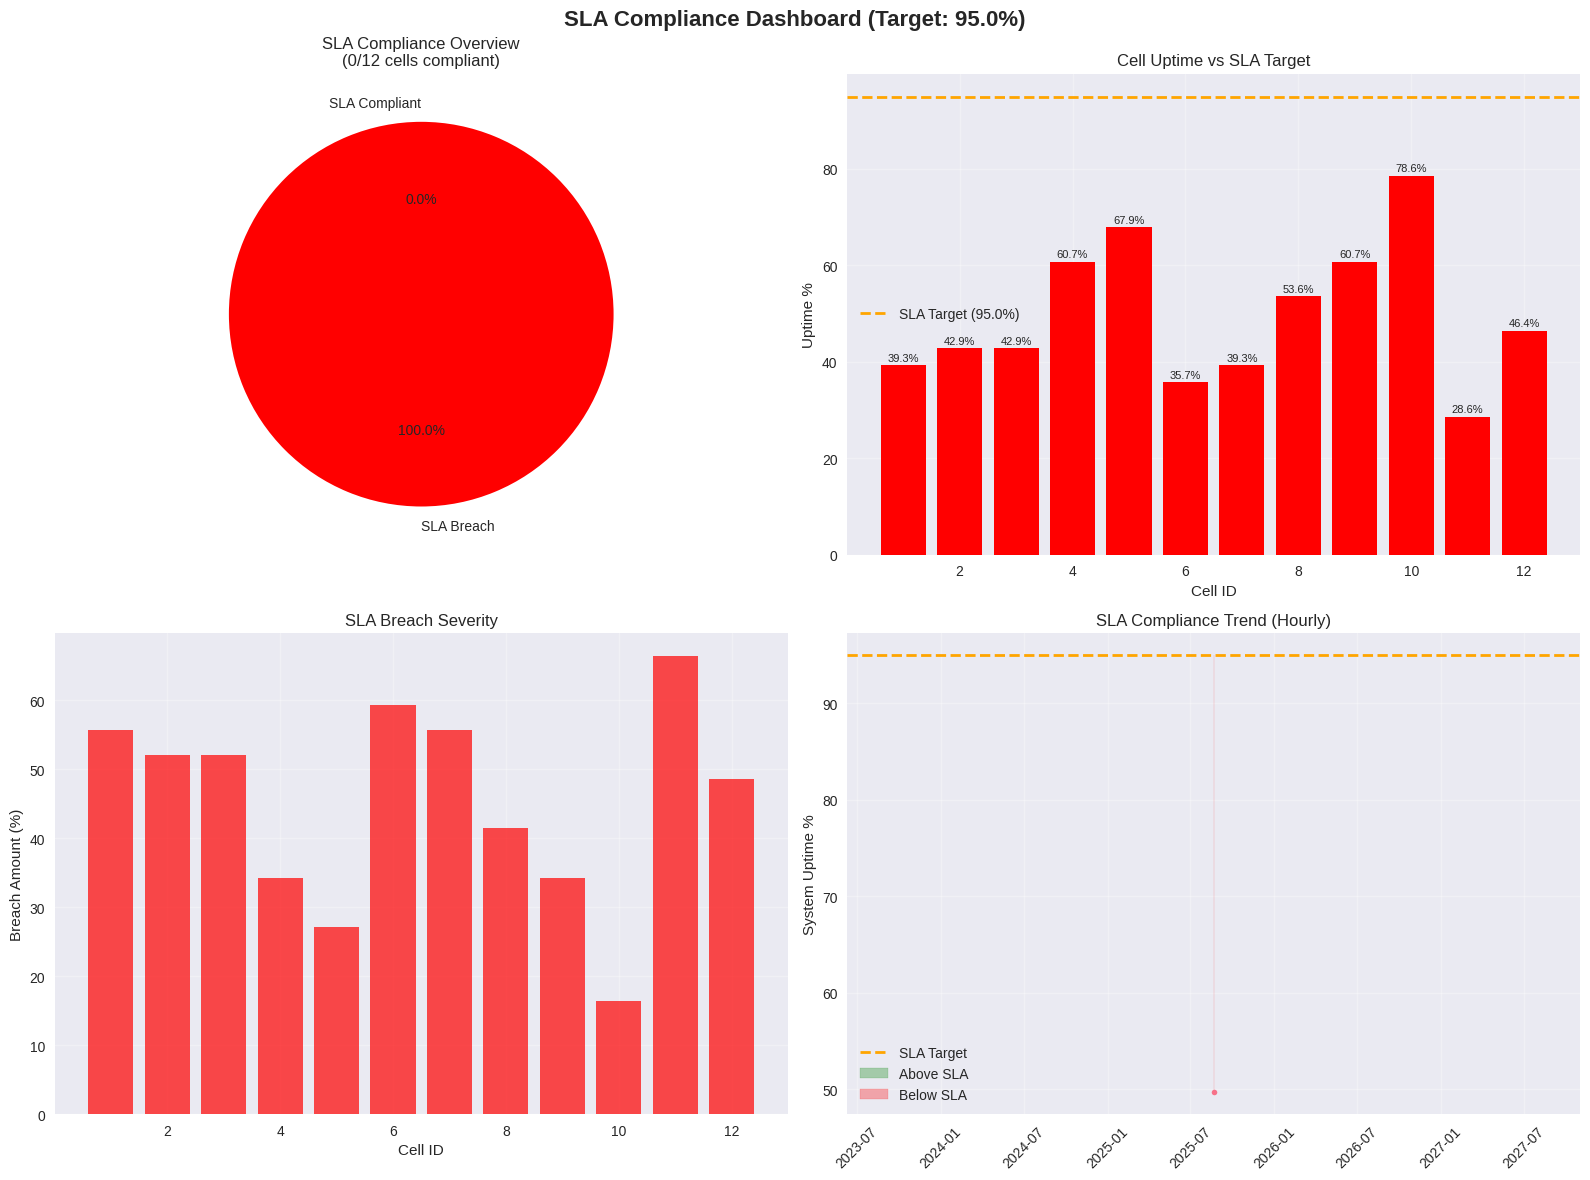


📋 SLA COMPLIANCE REPORT
Target SLA: 95.0%
Monitoring Period: 0.0 hours

Overall Compliance: 0/12 cells (0.0%)
System Average Uptime: 49.70%

🚨 SLA BREACHES:
  • Cell 1: 39.3% (breach: 55.7%)
  • Cell 2: 42.9% (breach: 52.1%)
  • Cell 3: 42.9% (breach: 52.1%)
  • Cell 4: 60.7% (breach: 34.3%)
  • Cell 5: 67.9% (breach: 27.1%)
  • Cell 6: 35.7% (breach: 59.3%)
  • Cell 7: 39.3% (breach: 55.7%)
  • Cell 8: 53.6% (breach: 41.4%)
  • Cell 9: 60.7% (breach: 34.3%)
  • Cell 10: 78.6% (breach: 16.4%)
  • Cell 11: 28.6% (breach: 66.4%)
  • Cell 12: 46.4% (breach: 48.6%)

💾 SLA report exported to: sla_compliance_report.csv


In [14]:
if not df.empty:
    # SLA compliance analysis
    SLA_TARGET = 95.0  # 95% uptime SLA
    
    # Calculate SLA metrics
    sla_metrics = df.groupby('cell_id').agg({
        'status_numeric': ['mean', 'count'],
        'ts': ['min', 'max']
    })
    
    sla_metrics.columns = ['uptime_pct', 'total_events', 'first_seen', 'last_seen']
    sla_metrics['uptime_pct'] *= 100
    sla_metrics['sla_compliant'] = sla_metrics['uptime_pct'] >= SLA_TARGET
    sla_metrics['sla_breach'] = SLA_TARGET - sla_metrics['uptime_pct']
    sla_metrics['monitoring_duration'] = (sla_metrics['last_seen'] - sla_metrics['first_seen']).dt.total_seconds() / 3600
    
    # SLA Dashboard
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'SLA Compliance Dashboard (Target: {SLA_TARGET}%)', fontsize=16, fontweight='bold')
    
    # 1. SLA compliance overview
    compliant_count = sla_metrics['sla_compliant'].sum()
    total_cells = len(sla_metrics)
    
    labels = ['SLA Compliant', 'SLA Breach']
    sizes = [compliant_count, total_cells - compliant_count]
    colors = ['green', 'red']
    
    axes[0,0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[0,0].set_title(f'SLA Compliance Overview\n({compliant_count}/{total_cells} cells compliant)')
    
    # 2. Uptime by cell with SLA line
    cell_ids = sla_metrics.index
    uptimes = sla_metrics['uptime_pct']
    colors = ['green' if x >= SLA_TARGET else 'red' for x in uptimes]
    
    bars = axes[0,1].bar(cell_ids, uptimes, color=colors)
    axes[0,1].axhline(y=SLA_TARGET, color='orange', linestyle='--', linewidth=2, label=f'SLA Target ({SLA_TARGET}%)')
    axes[0,1].set_title('Cell Uptime vs SLA Target')
    axes[0,1].set_ylabel('Uptime %')
    axes[0,1].set_xlabel('Cell ID')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, uptime in zip(bars, uptimes):
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                      f'{uptime:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # 3. SLA breach severity
    breach_cells = sla_metrics[~sla_metrics['sla_compliant']]
    if not breach_cells.empty:
        axes[1,0].bar(breach_cells.index, breach_cells['sla_breach'], color='red', alpha=0.7)
        axes[1,0].set_title('SLA Breach Severity')
        axes[1,0].set_ylabel('Breach Amount (%)')
        axes[1,0].set_xlabel('Cell ID')
        axes[1,0].grid(True, alpha=0.3)
    else:
        axes[1,0].text(0.5, 0.5, 'No SLA Breaches\n✅ All cells compliant', 
                      ha='center', va='center', transform=axes[1,0].transAxes, 
                      fontsize=14, color='green', fontweight='bold')
        axes[1,0].set_title('SLA Breach Severity')
    
    # 4. SLA trend over time
    df_sla_trend = df.set_index('ts').groupby('cell_id')['status_numeric'].resample('1H').mean().reset_index()
    sla_trend = df_sla_trend.groupby('ts')['status_numeric'].mean() * 100
    
    axes[1,1].plot(sla_trend.index, sla_trend.values, linewidth=2, marker='o', markersize=4)
    axes[1,1].axhline(y=SLA_TARGET, color='orange', linestyle='--', linewidth=2, label=f'SLA Target')
    axes[1,1].fill_between(sla_trend.index, sla_trend.values, SLA_TARGET, 
                          where=(sla_trend.values >= SLA_TARGET), color='green', alpha=0.3, label='Above SLA')
    axes[1,1].fill_between(sla_trend.index, sla_trend.values, SLA_TARGET, 
                          where=(sla_trend.values < SLA_TARGET), color='red', alpha=0.3, label='Below SLA')
    axes[1,1].set_title('SLA Compliance Trend (Hourly)')
    axes[1,1].set_ylabel('System Uptime %')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # SLA Report
    print("\n📋 SLA COMPLIANCE REPORT")
    print("=" * 50)
    print(f"Target SLA: {SLA_TARGET}%")
    print(f"Monitoring Period: {sla_metrics['monitoring_duration'].mean():.1f} hours")
    print(f"\nOverall Compliance: {compliant_count}/{total_cells} cells ({compliant_count/total_cells*100:.1f}%)")
    print(f"System Average Uptime: {sla_metrics['uptime_pct'].mean():.2f}%")
    
    if not breach_cells.empty:
        print("\n🚨 SLA BREACHES:")
        for cell_id, row in breach_cells.iterrows():
            print(f"  • Cell {cell_id}: {row['uptime_pct']:.1f}% (breach: {row['sla_breach']:.1f}%)")
    
    # Export SLA report
    sla_report = sla_metrics.round(2)
    sla_report.to_csv('sla_compliance_report.csv')
    print(f"\n💾 SLA report exported to: sla_compliance_report.csv")

## 🔄 Real-time Monitoring (Optional)

📊 Loaded 336 records from 12 cells
📅 Time range: 2025-08-20 20:44:27.866000 to 2025-08-20 20:44:55.268000


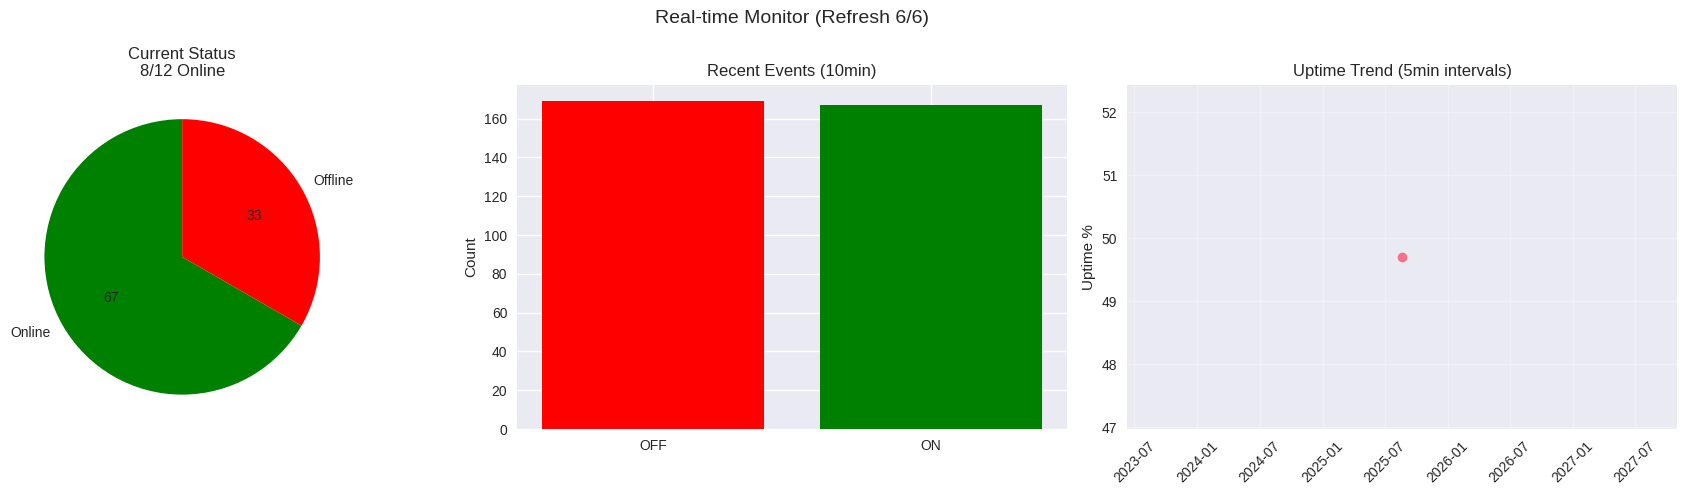

🕐 03:10:59 - System Status: 8/12 cells online (66.7%)
🚨 ALERT: System availability below 80%!

💡 To enable real-time monitoring, uncomment the last line above


In [15]:
# Real-time monitoring function (uncomment to use)
def real_time_monitor(duration_minutes=5, refresh_seconds=30):
    """
    Real-time monitoring dashboard that updates every refresh_seconds
    """
    from IPython.display import clear_output, display
    import time
    
    iterations = (duration_minutes * 60) // refresh_seconds
    
    for i in range(int(iterations)):
        clear_output(wait=True)
        
        # Load fresh data
        current_df = load_data(hours=0.5)  # Last 30 minutes
        
        if not current_df.empty:
            # Quick dashboard
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            fig.suptitle(f'Real-time Monitor (Refresh {i+1}/{int(iterations)})', fontsize=14)
            
            # Current system status
            current_status = current_df.groupby('cell_id')['status_numeric'].last()
            online_count = current_status.sum()
            total_count = len(current_status)
            
            axes[0].pie([online_count, total_count-online_count], 
                       labels=['Online', 'Offline'], colors=['green', 'red'],
                       autopct='%1.0f', startangle=90)
            axes[0].set_title(f'Current Status\n{online_count}/{total_count} Online')
            
            # Recent activity
            recent_events = current_df.set_index('ts').last('10T')
            event_counts = recent_events.groupby('status').size()
            if not event_counts.empty:
                axes[1].bar(event_counts.index, event_counts.values, 
                           color=['red', 'green'])
                axes[1].set_title('Recent Events (10min)')
                axes[1].set_ylabel('Count')
            
            # System uptime trend
            uptime_trend = current_df.set_index('ts').groupby('cell_id')['status_numeric'].resample('5T').mean().reset_index()
            system_trend = uptime_trend.groupby('ts')['status_numeric'].mean() * 100
            
            axes[2].plot(system_trend.index, system_trend.values, 'o-')
            axes[2].set_title('Uptime Trend (5min intervals)')
            axes[2].set_ylabel('Uptime %')
            axes[2].tick_params(axis='x', rotation=45)
            axes[2].grid(True, alpha=0.3)
            
            plt.tight_layout()
            display(plt.gcf())
            plt.close()
            
            # Status summary
            print(f"🕐 {datetime.now().strftime('%H:%M:%S')} - System Status: {online_count}/{total_count} cells online ({online_count/total_count*100:.1f}%)")
            
            # Alert for critical issues
            if online_count/total_count < 0.8:
                print("🚨 ALERT: System availability below 80%!")
        
        time.sleep(refresh_seconds)

# Uncomment to run real-time monitoring
real_time_monitor(duration_minutes=1, refresh_seconds=10)

print("\n💡 To enable real-time monitoring, uncomment the last line above")